# Data Cleaning

### Objectives

1. Load in the raw dataset for further analysis and preporation for data cleaning.
2. Revisit correlation and perform a PPS (Predictive Power Score) Study.
3. Inspect the data set for missing values, with a focus on the features highlighted in the DataAnalysis Notebook.
4. Having dealt with any missing values split the now clean data set into Train and Test sets.
5. Push these new data sets to the repo ready for feature engineering.

### Inputs

1. Our house_price_records data that we collected in our DataCollection Notebook, found at inputs/datasets/raw/house-price-20211124T154130z/house-price/house_price_records.csv 

### Additional Comments

* In case you have any additional comments that don't fit in the previous bullets, please state them here.

___

## Change working Directory

* We access the current directory with os.getcwd()

In [1]:
import os
current_dir = os.getcwd()
current_dir

'/workspace/CI-Project-5-Predictive-Analytics/jupyter_notebooks'


We want to make the parent of the current directory the new current directory

* os.path.dirname() gets the parent directory
* os.chir() defines the new current directory

In [2]:
os.chdir(os.path.dirname(current_dir))
print("You set a new current directory")

You set a new current directory


Confirm the new current directory

In [3]:
current_dir = os.getcwd()
current_dir

'/workspace/CI-Project-5-Predictive-Analytics'

## Load Collected Data and Import Necessary Packages

In [4]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = None
from pandas_profiling import ProfileReport
import matplotlib.pyplot as plt
import seaborn as sns
import ppscore as pps
from feature_engine.imputation import ArbitraryNumberImputer, CategoricalImputer
from sklearn.pipeline import Pipeline

/tmp/ipykernel_1249/3941373629.py:4: DeprecationWarning: `import pandas_profiling` is going to be deprecated by April 1st. Please use `import ydata_profiling` instead.
  from pandas_profiling import ProfileReport


* Firstly load both datasets ready for data evalustaion and cleaning. 

In [5]:
df = (pd.read_csv("inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/house_prices_records.csv"))
df.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,2003.0,1710,Gd,8450,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,1976.0,1262,TA,9600,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,2001.0,1786,Gd,11250,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,1998.0,1717,Gd,9550,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,2000.0,2198,Gd,14260,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000


In [6]:
df_inherited = (pd.read_csv("inputs/datasets/raw/house-price-20211124T154130Z-001/house-price/inherited_houses.csv"))
df_inherited.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,GarageYrBlt,GrLivArea,KitchenQual,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,1961.0,896,TA,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,1958.0,1329,Gd,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,1997.0,1629,TA,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,1998.0,1604,Gd,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


___

## Data Exploration

Having loaded our data we want to assess the distrobution of the variables that contain missing data.

In [ ]:
vars_with_missing_data = df.columns[df.isna().sum() > 0].to_list()
vars_with_missing_data

We can then run the Pandas Profile Report again, however this time we have singled out the columns that contain missing features in order to get a better understanding of their distribution.

In [ ]:
if vars_with_missing_data:
    profile = ProfileReport(df=df[vars_with_missing_data], minimal=True)
    profile.to_notebook_iframe()
else:
    print("There are no variables with missing data")

___

### PPS Analysis and Revisit of Correlation

* The Code utilised here was taken from the Code Isntitute lessons focused around PPS (Predictive Power score).
* We are utilising heatmaps here to review the PPS and correlation between our target Sales Price and other features.

In [7]:

def heatmap_corr(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[np.triu_indices_from(mask)] = True
        mask[abs(df) < threshold] = True

        fig, axes = plt.subplots(figsize=figsize)
        sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                    mask=mask, cmap='viridis', annot_kws={"size": font_annot}, ax=axes,
                    linewidth=0.5
                    )
        axes.set_yticklabels(df.columns, rotation=0)
        plt.ylim(len(df.columns), 0)
        plt.show()


def heatmap_pps(df, threshold, figsize=(20, 12), font_annot=8):
    if len(df.columns) > 1:
        mask = np.zeros_like(df, dtype=bool)
        mask[abs(df) < threshold] = True
        fig, ax = plt.subplots(figsize=figsize)
        ax = sns.heatmap(df, annot=True, xticklabels=True, yticklabels=True,
                         mask=mask, cmap='rocket_r', annot_kws={"size": font_annot},
                         linewidth=0.05, linecolor='grey')
        plt.ylim(len(df.columns), 0)
        plt.show()


def CalculateCorrAndPPS(df):
    df_corr_spearman = df.corr(method="spearman")
    df_corr_pearson = df.corr(method="pearson")

    pps_matrix_raw = pps.matrix(df)
    pps_matrix = pps_matrix_raw.filter(['x', 'y', 'ppscore']).pivot(columns='x', index='y', values='ppscore')

    pps_score_stats = pps_matrix_raw.query("ppscore < 1").filter(['ppscore']).describe().T
    print("PPS threshold - check PPS score IQR to decide threshold for heatmap \n")
    print(pps_score_stats.round(3))

    return df_corr_pearson, df_corr_spearman, pps_matrix


def DisplayCorrAndPPS(df_corr_pearson, df_corr_spearman, pps_matrix, CorrThreshold, PPS_Threshold,
                      figsize=(20, 12), font_annot=8):

    print("\n")

    print("\n")
    print("*** Heatmap: Spearman Correlation ***")
    print("It evaluates monotonic relationship \n")
    heatmap_corr(df=df_corr_spearman, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Pearson Correlation ***")
    print("It evaluates the linear relationship between two continuous variables \n")
    heatmap_corr(df=df_corr_pearson, threshold=CorrThreshold, figsize=figsize, font_annot=font_annot)

    print("\n")
    print("*** Heatmap: Power Predictive Score (PPS) ***")
    print(f"PPS detects linear or non-linear relationships between two columns.\n"
          f"The score ranges from 0 (no predictive power) to 1 (perfect predictive power) \n")
    heatmap_pps(df=pps_matrix, threshold=PPS_Threshold, figsize=figsize, font_annot=font_annot)


* Calculate the PPS (Predictive Power Score)

In [8]:
df_corr_pearson, df_corr_spearman, pps_matrix = CalculateCorrAndPPS(df)

/tmp/ipykernel_1249/3974993058.py:30: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_spearman = df.corr(method="spearman")
/tmp/ipykernel_1249/3974993058.py:31: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_corr_pearson = df.corr(method="pearson")
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=4.
  warnings.warn(
/workspace/.pip-modules/lib/python3.8/site-packages/sklearn/model_selection/_split.py:700: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=4.
  warni

PPS threshold - check PPS score IQR to decide threshold for heatmap 

         count   mean    std  min  25%  50%    75%    max
ppscore  552.0  0.055  0.104  0.0  0.0  0.0  0.066  0.702


* Below is the calling of our above function, we have set the PPS_threshhold at 0.2 in order to get a visualisation of features that have a relativly weak to strong predictive power. A score of less then 0.2 would mean a very weak predictive power and would arguably not be worth our time investigating.
* As seen in the previous notebook the features we highlighted as potentail features of importance showed a strong corralation, as such the correlation threshhold has been set to 0.5 and we would hope to see all 6 of these features present in the heat maps.





*** Heatmap: Spearman Correlation ***
It evaluates monotonic relationship 



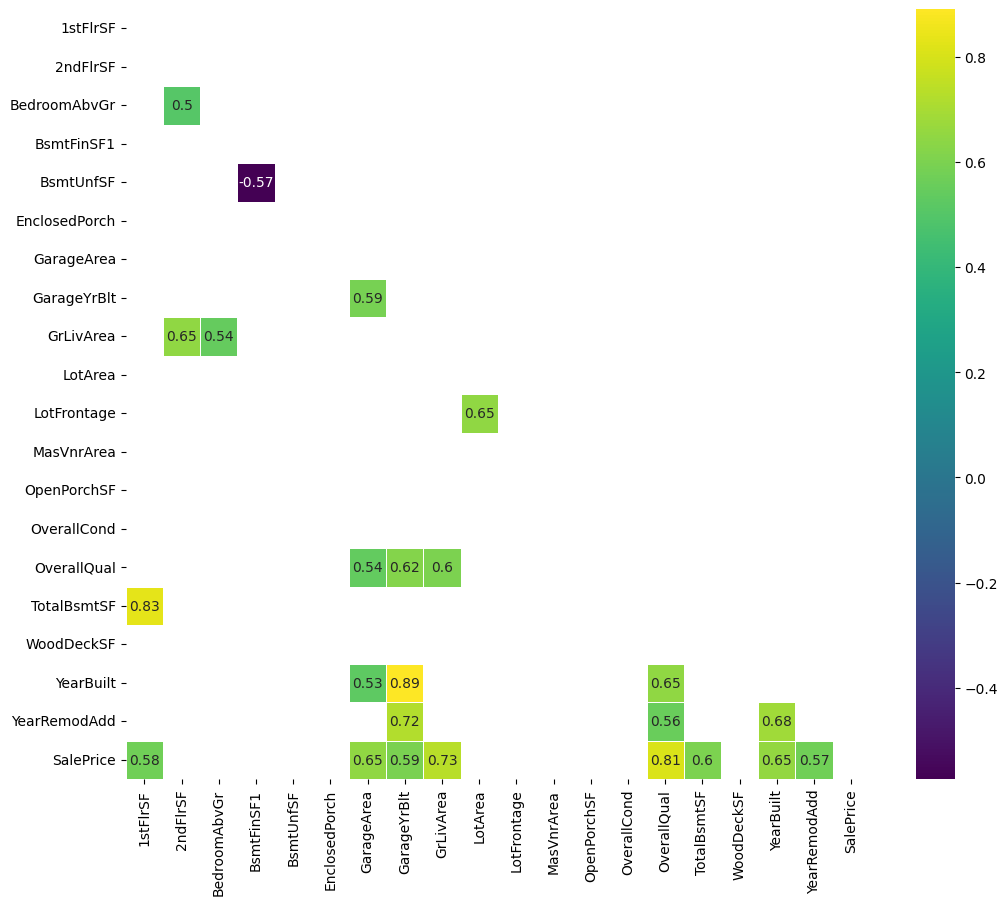



*** Heatmap: Pearson Correlation ***
It evaluates the linear relationship between two continuous variables 



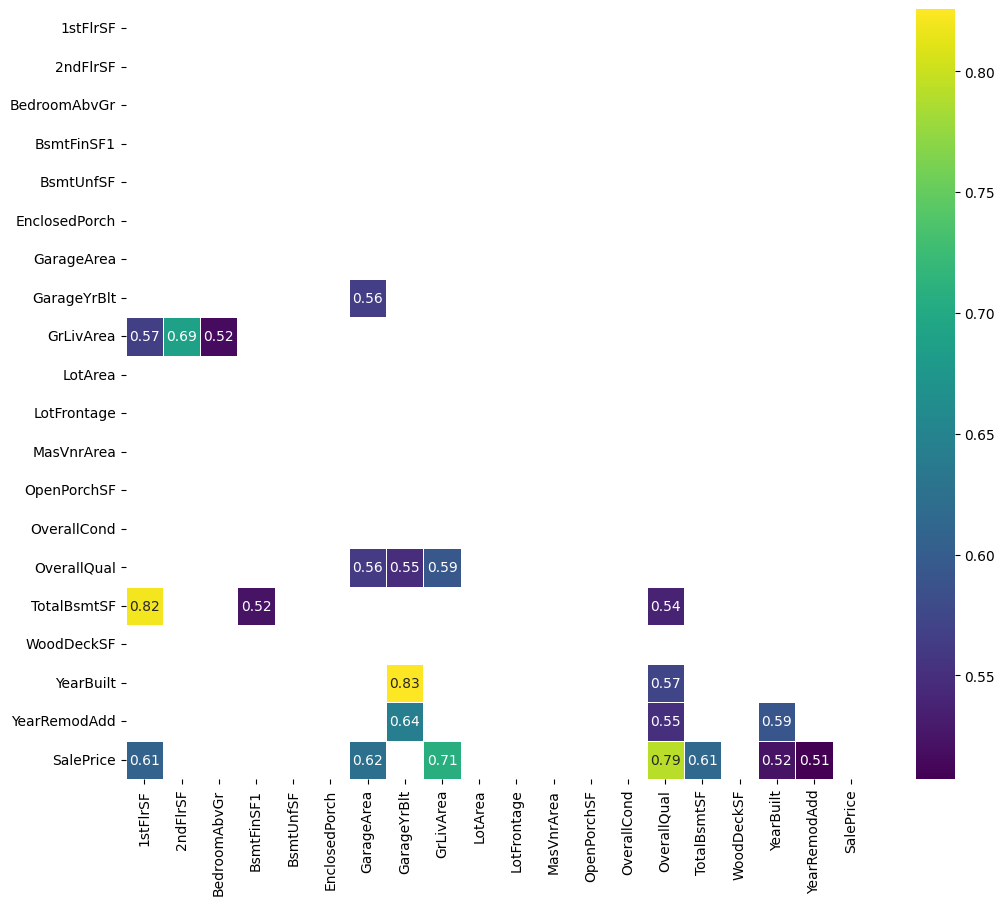



*** Heatmap: Power Predictive Score (PPS) ***
PPS detects linear or non-linear relationships between two columns.
The score ranges from 0 (no predictive power) to 1 (perfect predictive power) 



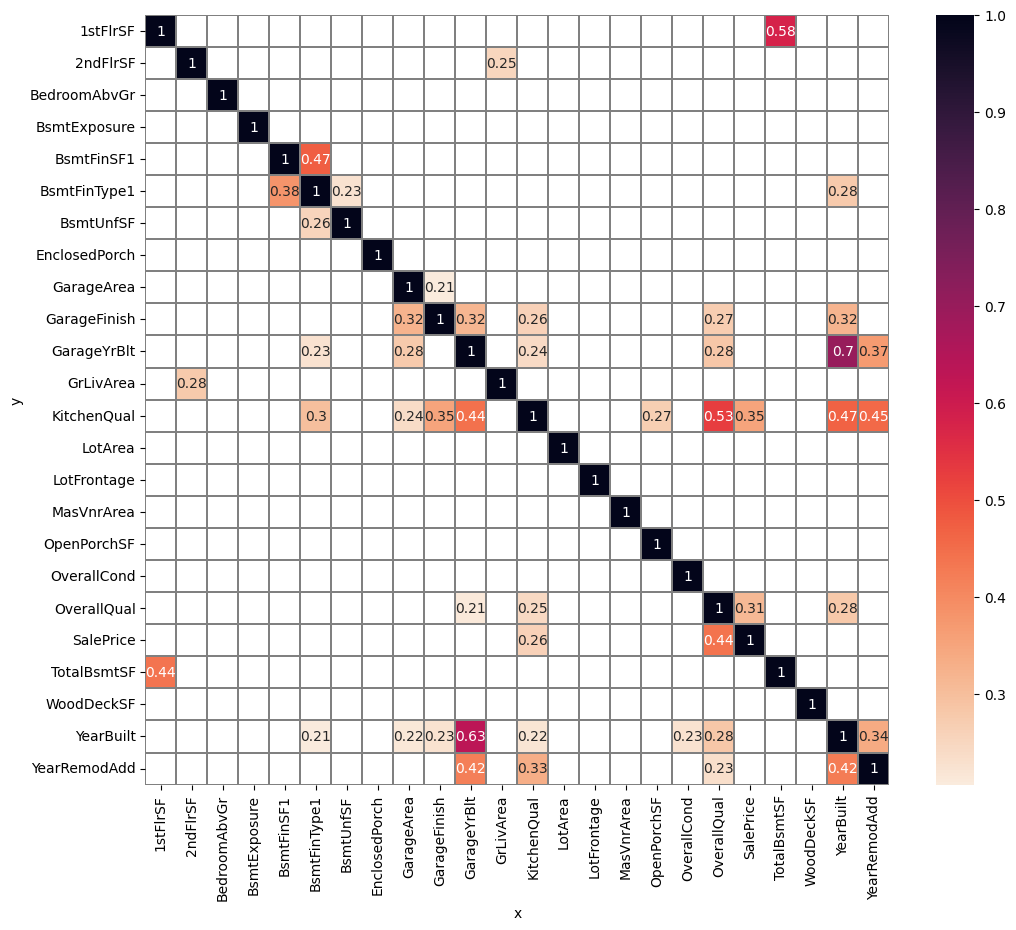

In [9]:
DisplayCorrAndPPS(df_corr_pearson = df_corr_pearson,
                  df_corr_spearman = df_corr_spearman, 
                  pps_matrix = pps_matrix,
                  CorrThreshold = 0.5, PPS_Threshold =0.2,
                  figsize=(12,10), font_annot=10)

___

## Further Data Analysis
### Missing data analysis

In [10]:
def EvaluateMissingData(df):
    missing_data_absolute = df.isnull().sum()
    missing_data_percentage = round(missing_data_absolute/len(df)*100, 2)
    df_missing_data = (pd.DataFrame(
                            data={"RowsWithMissingData": missing_data_absolute,
                                   "PercentageOfDataset": missing_data_percentage,
                                   "DataType": df.dtypes}
                                    )
                          .sort_values(by=['PercentageOfDataset'], ascending=False)
                          .query("PercentageOfDataset > 0")
                          )

    return df_missing_data


In [11]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


In [12]:
EvaluateMissingData(df_inherited)

,RowsWithMissingData,PercentageOfDataset,DataType


##### Results of missing data evaluation

* As we can see we have 9 columns that contain missing data, with both EnclosedPorch and WoodDeckSF having a hugely significant portion of their data missing.
* The other columns do not have nearly as much missing data as the previously mentioned two, however the amount if missing data is still an issue.
* The brightside here is that none of the features that were intially flagged as potentially important in the previous notebook appear in this list.

#### Effects of data cleaning methods

* In the previous notebook we completed some very simple data cleaning just to get a rough look at what effect it would have on the features that we identefied as potentally important. We wanted to see there that if after some simple cleaning and engineering whether those features remained the most important.
* The above PPS and correlation tests have then reinforced that based on the raw data we collected the top features that look to be able to predict SalePrice are:
    1. A large 1st floor square footage. (1stFlrSF)
    2. A large garage square footage. (GarageArea)
    3. A large above grade (ground) living area square footage. (GrLivArea)
    4. A high overall quality. (OverallQual)
    5. A large basement square footage. (TotalBsmtSF)
    6. A house built more recently. (YearBuilt)


* What we shall now look at is a more in-depth look into the effects of different data cleaning methods, The code below has been taken from the Code Institute Lessons relating to Predictive Analytics.
    * The below function assess the effect of different data cleaning methods such replacing missing numerical values with the Mean or the Median, and replacing Categorical values with 'Missing' or the most frequently seen value. 
    * Once we have gone through and cleaned our data producing a new cleaned dataframe we shall use this function to evaluate any significant changes to the original. 

In [13]:
import seaborn as sns
sns.set(style="whitegrid")
import matplotlib.pyplot as plt

def DataCleaningEffect(df_original,df_cleaned,variables_applied_with_method):

  flag_count=1 # Indicate the plot number
  
  # Distinguish between numerical and categorical variables
  categorical_variables = df_original.select_dtypes(exclude=['number']).columns 

  # scan over the variables, 
    # first on variables that you applied to the method
    # if the variable is numerical plot a histogram, if categorical plot a barplot
  for set_of_variables in [variables_applied_with_method]:
    print("\n=====================================================================================")
    print(f"* Distribution Effect Analysis After Data Cleaning Method in the following variables:")
    print(f"{set_of_variables} \n\n")
  

    for var in set_of_variables:
      if var in categorical_variables:  # it is categorical variable: barplot
        
        df1 = pd.DataFrame({"Type":"Original","Value":df_original[var]})
        df2 = pd.DataFrame({"Type":"Cleaned","Value":df_cleaned[var]})
        dfAux = pd.concat([df1, df2], axis=0)
        fig , axes = plt.subplots(figsize=(15, 5))
        sns.countplot(hue='Type', data=dfAux, x="Value",palette=['#432371',"#FAAE7B"])
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.xticks(rotation=90)
        plt.legend() 

      else: # it is numerical variable: histogram

        fig , axes = plt.subplots(figsize=(10, 5))
        sns.histplot(data=df_original, x=var, color="#432371", label='Original', kde=True,element="step", ax=axes)
        sns.histplot(data=df_cleaned, x=var, color="#FAAE7B", label='Cleaned', kde=True,element="step", ax=axes)
        axes.set(title=f"Distribution Plot {flag_count}: {var}")
        plt.legend() 

      plt.show()
      flag_count+= 1

___

## Data Cleaning

* We can start the cleaning process by returning to an earlier function and pulling our columns that contain missing data.

In [14]:
EvaluateMissingData(df)

,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1324,90.68,float64
WoodDeckSF,1305,89.38,float64
LotFrontage,259,17.74,float64
GarageFinish,162,11.10,object
BsmtFinType1,114,7.81,object
BedroomAbvGr,99,6.78,float64
2ndFlrSF,86,5.89,float64
GarageYrBlt,81,5.55,float64
MasVnrArea,8,0.55,float64


* As previously stated both EnclosedPorch and WoodDeckSF have an extreamly high percentage of null values. It is therefore not viable to attempt to impute any values in place of these, for this reason we shall be dropping these columns entirely from our dataset.
* LotFrontage and GarageFinish also have a high percentage of null values. Both above 10%. They shall not be immediatly dropped without evaluation however as they may still provide insights after data cleaning.
* The remaining 5 variables will all be cleaned and evaluated using the function defined above.

* It is my assumption that due to the fact none of these variables have been flagged in any data analysis as potentially useful for predicting SalesPrice that after data cleaning they will still prove to be unimportant, however we can not confirm this assumption without performing the relevent data cleaning and subsequent evaluation. The only 2 exceptoions to this are EnclosedPorch and WoodDeckSF. Both of which are float64 variables with 90% null values meaning any mean, median or arbitary number imputation would not be close to a relistic representation of the data and will not aid in our predictions and could even have a negative impact if any.

#### Data cleaning we will try initially
1. Drop - ['EnclosedPorch', 'WoodDeckSF' ]
2. Impute the Mean - ['LotFrontage', 'BedroomAbvGr', '2ndFlrSF', 'GarageYrBlt', 'MasVnrArea' ]
3. Impute 'Missing' - ['GarageFinish', 'BsmtFinType1' ]

___

## Splt the cleaned data

The first step when cleaning is to create a copy of our dataset.

In [15]:
df_clean = df.copy()
print(df_clean.shape)

(1460, 24)


We then split our original dataset into train and test sets.

In [16]:
from sklearn.model_selection import train_test_split
TrainSet, TestSet, _, __ = train_test_split(
                                        df,
                                        df['SalePrice'],
                                        test_size=0.2,
                                        random_state=0)

print(f"TrainSet shape: {TrainSet.shape} \nTestSet shape: {TestSet.shape}")

TrainSet shape: (1168, 24) 
TestSet shape: (292, 24)


We can now evaluate the spread of missing values with in the test set that we have just created.

In [17]:
df_missing_data = EvaluateMissingData(TrainSet)
print(f"* There are {df_missing_data.shape[0]} variables with missing data \n")
df_missing_data

* There are 9 variables with missing data 



,RowsWithMissingData,PercentageOfDataset,DataType
EnclosedPorch,1056,90.41,float64
WoodDeckSF,1034,88.53,float64
LotFrontage,212,18.15,float64
GarageFinish,131,11.22,object
BsmtFinType1,89,7.62,object
BedroomAbvGr,80,6.85,float64
2ndFlrSF,60,5.14,float64
GarageYrBlt,58,4.97,float64
MasVnrArea,6,0.51,float64


* Upon reviweing the test set we can see the split is extrealy similar to the split of the raw data. As expected the same 9 variables have been flagged with a slight decrease in the the percantage of missing data, however we still see theat EnclosedPorch and WoodDeckSF have 90.41% and 88.53% missing data respectivly so we shall copntinue to work on the assumption that they will be of no help in answering the business requiremets and will be dropped due to this.

___

### Step 1 of data cleaning

* As stated above we want to drop EnclosedPorch and WoodDeckSF as they have a large majority of null values and will likely not effect our predictions in any meaningful way.
* In order to achieve this we will run the following code, utilising the DropFeatures meathod from feature_engine and will apply this change to both the train and test set.

In [22]:
from feature_engine.selection import DropFeatures
variables = ['EnclosedPorch', 'WoodDeckSF']
imputer = DropFeatures(features_to_drop=variables)
imputer.fit(TrainSet)
TrainSet, TestSet = imputer.transform(TrainSet), imputer.transform(TestSet)
TestSet.head()

KeyError: "None of [Index(['EnclosedPorch', 'WoodDeckSF'], dtype='object')] are in the [columns]"

## Push files to Repo

* If you do not need to push files to Repo, you may replace this section with "Conclusions and Next Steps" and state your conclusions and next steps.

In [ ]:
import os
try:
  # create here your folder
  # os.makedirs(name='')
except Exception as e:
  print(e)